# Install Dependencies

In [ ]:
!pip install tensorflow==2.0.0 keras==2.3.1 h5py==2.10.0 numpy==1.17.4 mtcnn==0.1.0 scikit-learn==0.22.1 matplotlib==3.1.2 pillow==6.2.1 opencv-python==4.1.0.25 protobuf==3.19.6 keras_vggface python==3.7.5

# 1. Data Collection and Dataset Creation:

This script captures faces from a webcam using MTCNN for face detection, resizes the faces to a specified size, and then saves the images to train and validation directories. The images can be used for training a face recognition model. The ratio of training to validation images can be set by the TRAIN_RATIO parameter. Images are displayed as they are captured with a count and the directory they are being saved to. Pressing 'Enter' will end the capture.This script captures faces from a webcam using MTCNN for face detection, resizes the faces to a specified size, and then saves the images to train and validation directories. The images can be used for training a face recognition model. The ratio of training to validation images can be set by the TRAIN_RATIO parameter. Images are displayed as they are captured with a count and the directory they are being saved to. Pressing 'Enter' will end the capture.

In [6]:
# Import required packages
import os
import cv2
from mtcnn import MTCNN

# Set parameters
WEBCAM_ID = 0  # ID of the webcam to use
TRAIN_RATIO = 0.8  # The proportion of images to use for training
TOTAL_IMAGES = 35  # Total number of images to capture
#REQUIRED_SIZE = (160, 160)  # Desired size of the output images for FaceNet
REQUIRED_SIZE = (224, 224)  # Desired size of the output images for VGGFace
NAME_OF_PERSON = 'name_of_person'  # Name of the person to be captured
DATASET_PATH = 'dataset'  # Directory to store the images

# Initialize the MTCNN detector for face detection
detector = MTCNN()

# Initialize the webcam video stream
cap = cv2.VideoCapture(WEBCAM_ID)
if not cap.isOpened():
    # Raise an exception if the video device could not be opened
    raise Exception("Could not open video device")

# Create directories to save the images for training and validation
# Use exist_ok=True to avoid an error if the directory already exists
os.makedirs(f'{DATASET_PATH}/train/{NAME_OF_PERSON}', exist_ok=True)
os.makedirs(f'{DATASET_PATH}/val/{NAME_OF_PERSON}', exist_ok=True)

# Print message indicating start of data collection
print(f'Starting data collection for {NAME_OF_PERSON}...')

for count in range(TOTAL_IMAGES):
    # Capture a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        # Break the loop if the frame couldn't be captured
        break

    # Convert the frame to RGB (as MTCNN expects images in RGB format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces in the frame using MTCNN
    results = detector.detect_faces(rgb_frame)

    if results:
        # Get the bounding box of the detected face
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)  # Ensure the coordinates are positive
        x2, y2 = x1 + width, y1 + height

        # Extract the face from the image and resize it to the required size
        face = cv2.resize(rgb_frame[y1:y2, x1:x2], REQUIRED_SIZE)

        # Determine if the image should be part of the training or validation set
        directory = 'train' if count < TRAIN_RATIO * TOTAL_IMAGES else 'val'
        # Construct the path for saving the image
        file_name_path = os.path.join(f'{DATASET_PATH}/{directory}/{NAME_OF_PERSON}', f'{count}.jpg')

        # Save the face image to the file (convert the image back to BGR format for saving)
        cv2.imwrite(file_name_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

        # Display count and path on the frame
        cv2.putText(frame, f'Count: {count}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.putText(frame, f'Directory: {file_name_path}', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Video', frame)

    # Break the loop if 'Enter' is pressed
    if cv2.waitKey(1) == 13:
        break

# Release the webcam video stream
cap.release()
# Close all OpenCV windows
cv2.destroyAllWindows()

# Print message indicating end of data collection
print(f'Finished data collection for {NAME_OF_PERSON}.')

Starting data collection for syeda...
Finished data collection for syeda.


# 2. Model Creation and Training:

## FaceNet + MTCNN + SVM

This code is for training a face recognition system. It loads images, detects faces using MTCNN, extracts face embeddings using a pre-trained FaceNet model, trains a SVM classifier on the embeddings, and then saves the trained SVM model and the label encoder.

INFO:root:Loading datasets from dataset/train and dataset/val
INFO:root:Unique train labels: ['arif' 'arman' 'chen' 'diksha' 'galib' 'hanna' 'hannas' 'mohanned'
 'raijin' 'syeda']
INFO:root:Unique test labels: ['arif' 'arman' 'chen' 'diksha' 'galib' 'hanna' 'hannas' 'mohanned'
 'raijin' 'syeda']


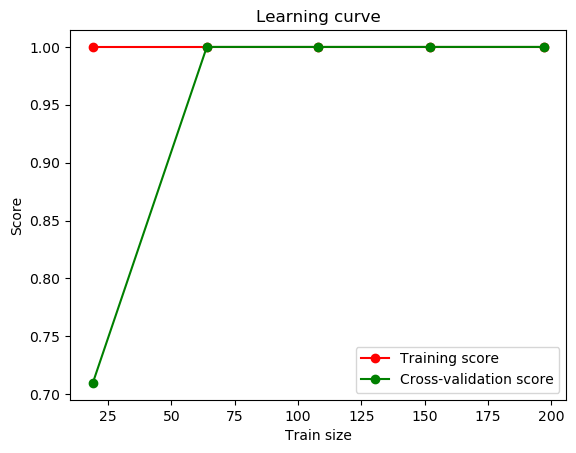

INFO:root:Class distribution: train = Counter({'raijin': 30, 'galib': 30, 'mohanned': 30, 'chen': 30, 'diksha': 30, 'hannas': 30, 'arif': 30, 'hanna': 30, 'arman': 28, 'syeda': 28}), test = Counter({'arman': 7, 'syeda': 7, 'raijin': 5, 'arif': 5, 'galib': 5, 'hannas': 5, 'chen': 5, 'hanna': 5, 'diksha': 5, 'mohanned': 5})


              precision    recall  f1-score   support

        arif       1.00      1.00      1.00         5
       arman       1.00      1.00      1.00         7
        chen       1.00      1.00      1.00         5
      diksha       1.00      1.00      1.00         5
       galib       1.00      1.00      1.00         5
       hanna       1.00      1.00      1.00         5
      hannas       1.00      1.00      1.00         5
    mohanned       1.00      1.00      1.00         5
      raijin       1.00      1.00      1.00         5
       syeda       1.00      1.00      1.00         7

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [7]:
from typing import Tuple, List
from pathlib import Path
import numpy as np
from PIL import Image
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import load_model
from joblib import dump
import logging
from collections import Counter
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO)

# Function to extract face from image files
def extract_face(filename: Path, required_size: Tuple[int, int] = (160, 160)) -> np.ndarray:
    # Open the image file and convert it to RGB
    image = Image.open(filename).convert('RGB')
    # Convert the image to numpy array
    pixels = np.array(image)
    # Instantiate the face detector
    detector = MTCNN()
    # Detect faces in the image
    results = detector.detect_faces(pixels)
    if results:
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        return np.array(Image.fromarray(face).resize(required_size))
    return None

# Function to load faces from a directory
def load_faces(directory: Path) -> List[np.ndarray]:
    faces = []
    for path in directory.iterdir():
        face = extract_face(path)
        if face is not None:
            faces.append(face)
    return faces

# Function to load datasets
def load_dataset(directory: Path) -> Tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    # Iterate through each directory
    for subdir in directory.iterdir():
        faces = load_faces(subdir)
        labels = [subdir.name]*len(faces)
        X.extend(faces)
        Y.extend(labels)

    # Convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Shuffle X and Y in unison
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    return X, Y

# Function to get embeddings from the model
def get_embeddings(model, faces):
    return [get_embedding(model, face_pixels) for face_pixels in faces]

# Function to get a single embedding
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    return model.predict(np.expand_dims(face_pixels, axis=0))[0]

# Function to normalize inputs
def normalize_inputs(trainX, testX):
    in_encoder = Normalizer(norm='l2')
    return in_encoder.transform(trainX), in_encoder.transform(testX)

# Function to encode labels
def encode_labels(trainy, testy):
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    return out_encoder.transform(trainy), out_encoder.transform(testy), out_encoder

# Function to train SVM model
def train_model(trainX, trainy):
    model = SVC(kernel='linear', probability=True)
    model.fit(trainX, trainy)
    return model

# Function to test model
def test_model(model, testX, testy, out_encoder):
    preds = model.predict(testX)
    print(classification_report(out_encoder.inverse_transform(testy), out_encoder.inverse_transform(preds)))

# Function to plot learning curve
def plot_learning_curve(estimator, X, y):
    cv = StratifiedKFold(n_splits=3)  # adjust n_splits as needed
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Train size")
    plt.ylabel("Score")
    plt.title("Learning curve")
    plt.legend(loc="best")
    plt.show()

# Main function to execute the steps
def main():
    facenet = load_model('models/facenet_keras.h5')

    logging.info("Loading datasets from dataset/train and dataset/val")

    # Load train and test datasets
    trainX, trainy = load_dataset(Path('dataset/train/'))
    testX, testy = load_dataset(Path('dataset/val/'))

    # Log unique labels
    logging.info(f"Unique train labels: {np.unique(trainy)}")
    logging.info(f"Unique test labels: {np.unique(testy)}")

    # Get embeddings for training and testing sets
    newTrainX = get_embeddings(facenet, trainX)
    newTestX = get_embeddings(facenet, testX)

    # Normalize inputs
    newTrainX, newTestX = normalize_inputs(newTrainX, newTestX)

    # Encode labels
    trainy, testy, out_encoder = encode_labels(trainy, testy)

    # Train the model
    model = train_model(newTrainX, trainy)

    # Plot learning curve
    plot_learning_curve(model, newTrainX, trainy)

    # Log class distribution
    logging.info(f"Class distribution: train = {Counter(out_encoder.inverse_transform(trainy))}, test = {Counter(out_encoder.inverse_transform(testy))}")

    # Test the model
    test_model(model, newTestX, testy, out_encoder)

    # Save the model and label encoder
    dump(model, 'models/svc_model_facenet.joblib')
    dump(out_encoder, 'models/label_encoder_facenet.joblib')

if __name__ == '__main__':
    main()

## VGGFace + MTCNN + SVM

94699520/94694792 [==============================] - 40s 0us/step


INFO:root:Loading datasets from dataset/train and dataset/val
INFO:root:Unique train labels: ['arif' 'arman' 'chen' 'diksha' 'galib' 'hanna' 'hannas' 'mohanned'
 'raijin' 'syeda']
INFO:root:Unique test labels: ['arif' 'arman' 'chen' 'diksha' 'galib' 'hanna' 'hannas' 'mohanned'
 'raijin' 'syeda']


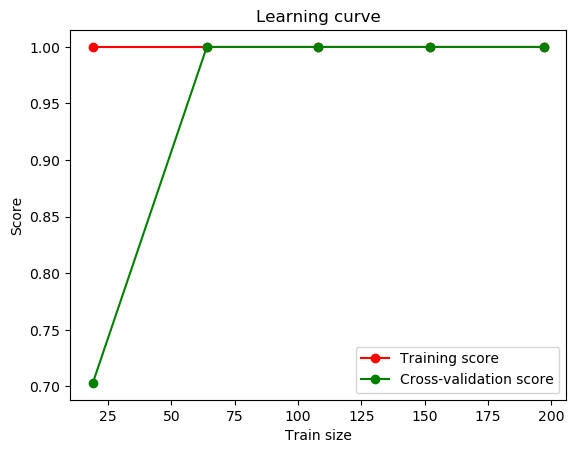

INFO:root:Class distribution: train = Counter({'arif': 30, 'mohanned': 30, 'chen': 30, 'raijin': 30, 'diksha': 30, 'galib': 30, 'hannas': 30, 'hanna': 30, 'arman': 28, 'syeda': 28}), test = Counter({'syeda': 7, 'arman': 7, 'chen': 5, 'hanna': 5, 'hannas': 5, 'galib': 5, 'mohanned': 5, 'raijin': 5, 'arif': 5, 'diksha': 5})


              precision    recall  f1-score   support

        arif       1.00      1.00      1.00         5
       arman       1.00      1.00      1.00         7
        chen       1.00      1.00      1.00         5
      diksha       1.00      1.00      1.00         5
       galib       1.00      1.00      1.00         5
       hanna       1.00      1.00      1.00         5
      hannas       1.00      1.00      1.00         5
    mohanned       1.00      1.00      1.00         5
      raijin       1.00      1.00      1.00         5
       syeda       1.00      1.00      1.00         7

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [8]:
from typing import Tuple, List
from pathlib import Path
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import classification_report
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import matplotlib.pyplot as plt
from joblib import dump
import logging
from collections import Counter
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO)

# Function to extract face from image files
def extract_face(filename: Path, required_size: Tuple[int, int] = (224, 224)) -> np.ndarray:
    # Open the image file and convert it to RGB
    image = Image.open(filename).convert('RGB')
    # Convert the image to numpy array
    pixels = np.array(image)
    # Instantiate the face detector
    detector = MTCNN()
    # Detect faces in the image
    results = detector.detect_faces(pixels)
    if results:
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        return np.array(Image.fromarray(face).resize(required_size))
    return None

# Function to load faces from a directory
def load_faces(directory: Path) -> List[np.ndarray]:
    faces = []
    for path in directory.iterdir():
        face = extract_face(path)
        if face is not None:
            faces.append(face)
    return faces

# Function to load datasets
def load_dataset(directory: Path) -> Tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    # Iterate through each directory
    for subdir in directory.iterdir():
        faces = load_faces(subdir)
        labels = [subdir.name]*len(faces)
        X.extend(faces)
        Y.extend(labels)

    # Convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Shuffle X and Y in unison
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    return X, Y

# Function to get embeddings from the model
def get_embeddings(model, faces):
    return [get_embedding(model, face_pixels) for face_pixels in faces]

# Function to get a single embedding
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    face_pixels = preprocess_input(face_pixels, version=2)  # preprocessing needed for VGGFace model
    return model.predict(np.expand_dims(face_pixels, axis=0))[0]

# Function to normalize inputs
def normalize_inputs(trainX, testX):
    in_encoder = Normalizer(norm='l2')
    return in_encoder.transform(trainX), in_encoder.transform(testX)

# Function to encode labels
def encode_labels(trainy, testy):
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    return out_encoder.transform(trainy), out_encoder.transform(testy), out_encoder

# Function to train SVM model
def train_model(trainX, trainy):
    model = SVC(kernel='linear', probability=True)
    model.fit(trainX, trainy)
    return model

# Function to test model
def test_model(model, testX, testy, out_encoder):
    preds = model.predict(testX)
    print(classification_report(out_encoder.inverse_transform(testy), out_encoder.inverse_transform(preds)))

# Function to plot learning curve
def plot_learning_curve(estimator, X, y):
    cv = StratifiedKFold(n_splits=3)  # adjust n_splits as needed
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Train size")
    plt.ylabel("Score")
    plt.title("Learning curve")
    plt.legend(loc="best")
    plt.show()

def main():
    vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')  # VGGFace model with resnet50 architecture

    logging.info("Loading datasets from dataset/train and dataset/val")

    # Load train and test datasets
    trainX, trainy = load_dataset(Path('dataset/train/'))
    testX, testy = load_dataset(Path('dataset/val/'))

    # Log unique labels
    logging.info(f"Unique train labels: {np.unique(trainy)}")
    logging.info(f"Unique test labels: {np.unique(testy)}")

    # Get embeddings for training and testing sets
    newTrainX = get_embeddings(vggface, trainX)
    newTestX = get_embeddings(vggface, testX)

    # Normalize inputs
    newTrainX, newTestX = normalize_inputs(newTrainX, newTestX)

    # Encode labels
    trainy, testy, out_encoder = encode_labels(trainy, testy)

    # Train the model
    model = train_model(newTrainX, trainy)

    # Plot learning curve
    plot_learning_curve(model, newTrainX, trainy)

    # Log class distribution
    logging.info(f"Class distribution: train = {Counter(out_encoder.inverse_transform(trainy))}, test = {Counter(out_encoder.inverse_transform(testy))}")

    # Test the model
    test_model(model, newTestX, testy, out_encoder)

    # Save the model and label encoder
    dump(model, 'models/svc_model_vgg.joblib')
    dump(out_encoder, 'models/label_encoder_vgg.joblib')

if __name__ == '__main__':
    main()


# 3. Real-time Face Recognition:

## FaceNet + MTCNN

This script runs face recognition in real-time from webcam feed. It uses MTCNN for face detection, a FaceNet model for creating face embeddings, and a trained SVM model for face classification.

In [2]:
# Import the necessary packages
import cv2  # OpenCV for image processing
import numpy as np  # For matrix operations
from mtcnn.mtcnn import MTCNN  # Multi-task Cascaded Convolutional Networks for face detection
from keras.models import load_model  # Loading Keras model
from sklearn.preprocessing import LabelEncoder, Normalizer  # Preprocessing for SVM
from sklearn.svm import SVC  # SVM model
from joblib import load  # To load trained models
import time  # To calculate FPS
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Define the FaceDetector class
class FaceDetector:
    # Initialize the FaceDetector class
    def __init__(self, facenet_model_path, svc_model_path, label_encoder_path):
        # Load MTCNN face detector
        self.detector = MTCNN()
        # Load FaceNet model for face embeddings
        self.facenet = load_model(facenet_model_path)
        # Initialize a normalizer to normalize face embeddings
        self.in_encoder = Normalizer(norm='l2')
        # Load a Label Encoder to decode the predicted class labels
        self.out_encoder = load(label_encoder_path)
        # Load the trained SVM model for face recognition
        self.model = load(svc_model_path)

    # Method to calculate face embeddings using FaceNet
    def get_embedding(self, face_pixels):
        # Standardize pixel values across channels (global)
        face_pixels = face_pixels.astype('float32')
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        return self.facenet.predict(np.expand_dims(face_pixels, axis=0))[0]

    # Method to predict the identity of a given face
    def predict_face(self, face):
        # Get the face embeddings
        face_embedding = self.get_embedding(face)
        # Normalize the embeddings
        samples = self.in_encoder.transform(np.expand_dims(face_embedding, axis=0))
        # Predict the class using SVM model
        yhat_class = self.model.predict(samples)
        # Predict the probability of the predicted class
        yhat_prob = self.model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0, class_index] * 100
        # Decode the class to get the person's name
        predict_names = self.out_encoder.inverse_transform(yhat_class)
        return predict_names[0], class_probability

    # Method to draw labels on the frame
    def draw_label_on_frame(self, frame, label, x1, y1):
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Method to process a frame for face detection and recognition
    def process_frame(self, frame):
        # Start the time counter
        start_time = time.time()
        # Convert the frame color to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Detect faces in the frame
        results = self.detector.detect_faces(rgb_frame)

        for result in results:
            # Get the bounding box coordinates
            x1, y1, width, height = result['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            # Extract the face
            face = rgb_frame[y1:y2, x1:x2]
            # Resize the face to 160x160 pixels
            face = cv2.resize(face, (160, 160))
            
            # Predict the face
            name, confidence = self.predict_face(face)
            # Prepare the label
            label = "%s : %.3f" % (name, confidence)
            # Draw a rectangle around the face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            # Draw the label on the frame
            self.draw_label_on_frame(frame, label, x1, y1)

        # Calculate the inference time and FPS
        inference_time = time.time() - start_time
        fps = 1 / inference_time
        # Prepare the label for FPS
        label = "Inference time: %.3f s, FPS: %.2f" % (inference_time, fps)
        # Draw the FPS on the frame
        cv2.putText(frame, label, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Display the frame
        cv2.imshow("Frame", frame)

    # Method to start the face detection and recognition process
    def run(self):
        # Start capturing video from the webcam
        cap = cv2.VideoCapture(0)
        try:
            # Continuously capture video until 'q' is pressed
            while True:
                ret, frame = cap.read()
                # If frame is not captured properly, break the loop
                if not ret:
                    break
                # Process the captured frame
                self.process_frame(frame)
                # Break the loop if 'q' is pressed
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        finally:
            # Release the video capture object
            cap.release()
            # Close all OpenCV windows
            cv2.destroyAllWindows()

# Check if this module is the main script
if __name__ == "__main__":
    # Create a FaceDetector object and start the face detection and recognition
    detector = FaceDetector('models/facenet_keras.h5', 'models/svc_model_facenet.joblib', 'models/label_encoder_facenet.joblib')
    detector.run()

Using TensorFlow backend.


## FaceNet + Yolo3Face

In [10]:
# Import the necessary packages
import cv2  # OpenCV for image processing
import numpy as np  # For matrix operations
from keras.models import load_model  # Loading Keras model
from sklearn.preprocessing import LabelEncoder, Normalizer  # Preprocessing for SVM
from sklearn.svm import SVC  # SVM model
from joblib import load  # To load trained models
import time  # To calculate FPS
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

class FaceDetector:
    def __init__(self, facenet_model_path, svc_model_path, label_encoder_path, yolo_weights_path, yolo_config_path):
        # Load YOLOFace
        self.net = cv2.dnn.readNet(yolo_weights_path, yolo_config_path)
        self.layer_names = self.net.getLayerNames()
        self.output_layers = [self.layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        
        # Load FaceNet model for face embeddings
        self.facenet = load_model(facenet_model_path)
        # Initialize a normalizer to normalize face embeddings
        self.in_encoder = Normalizer(norm='l2')
        # Load a Label Encoder to decode the predicted class labels
        self.out_encoder = load(label_encoder_path)
        # Load the trained SVM model for face recognition
        self.model = load(svc_model_path)

    def get_embedding(self, face_pixels):
        # Standardize pixel values across channels (global)
        face_pixels = face_pixels.astype('float32')
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        return self.facenet.predict(np.expand_dims(face_pixels, axis=0))[0]

    def predict_face(self, face):
        # Get the face embeddings
        face_embedding = self.get_embedding(face)
        # Normalize the embeddings
        samples = self.in_encoder.transform(np.expand_dims(face_embedding, axis=0))
        # Predict the class using SVM model
        yhat_class = self.model.predict(samples)
        # Predict the probability of the predicted class
        yhat_prob = self.model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0, class_index] * 100
        # Decode the class to get the person's name
        predict_names = self.out_encoder.inverse_transform(yhat_class)
        return predict_names[0], class_probability

    def draw_label_on_frame(self, frame, label, x1, y1):
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    def process_frame(self, frame):
        start_time = time.time()
        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    face = frame[y:y+h, x:x+w]
                    face = cv2.resize(face, (160, 160))
                    
                    # Predict the face
                    name, confidence = self.predict_face(face)
                    # Prepare the label
                    label = "%s : %.3f" % (name, confidence)
                    # Draw a rectangle around the face
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    # Draw the label on the frame
                    self.draw_label_on_frame(frame, label, x, y)

        inference_time = time.time() - start_time
        fps = 1 / inference_time
        label = "Inference time: %.3f s, FPS: %.2f" % (inference_time, fps)
        cv2.putText(frame, label, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Frame", frame)

    def run(self):
        cap = cv2.VideoCapture(0)
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                self.process_frame(frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        finally:
            cap.release()
            cv2.destroyAllWindows()

if __name__ == "__main__":
    # Create a FaceDetector object and start the face detection and recognition
    detector = FaceDetector('models/facenet_keras.h5', 'models/svc_model_facenet.joblib', 'models/label_encoder_facenet.joblib', 'models/yolov3-wider_16000.weights', 'models/yolov3-face.cfg')
    detector.run()


## VGGFace + MTCnn

In [11]:
# Import the necessary packages
import cv2  # OpenCV for image processing
import numpy as np  # For matrix operations
from mtcnn.mtcnn import MTCNN  # Multi-task Cascaded Convolutional Networks for face detection
from keras_vggface.vggface import VGGFace  # VGGFace model for face embeddings
from keras_vggface.utils import preprocess_input
from sklearn.preprocessing import LabelEncoder, Normalizer  # Preprocessing for SVM
from sklearn.svm import SVC  # SVM model
from joblib import load  # To load trained models
import time  # To calculate FPS

# Define the FaceDetector class
class FaceDetector:
    # Initialize the FaceDetector class
    def __init__(self, svc_model_path, label_encoder_path):
        # Load MTCNN face detector
        self.detector = MTCNN()
        # Load VGGFace model for face embeddings
        self.vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        # Initialize a normalizer to normalize face embeddings
        self.in_encoder = Normalizer(norm='l2')
        # Load a Label Encoder to decode the predicted class labels
        self.out_encoder = load(label_encoder_path)
        # Load the trained SVM model for face recognition
        self.model = load(svc_model_path)

    # Method to calculate face embeddings using VGGFace
    def get_embedding(self, face_pixels):
        # Scale pixel values
        face_pixels = face_pixels.astype('float32')
        # Standardize pixel values across channels (global)
        face_pixels = preprocess_input(face_pixels, version=2)
        return self.vggface.predict(np.expand_dims(face_pixels, axis=0))[0]

    # Method to predict the identity of a given face
    def predict_face(self, face):
        # Get the face embeddings
        face_embedding = self.get_embedding(face)
        # Normalize the embeddings
        samples = self.in_encoder.transform(np.expand_dims(face_embedding, axis=0))
        # Predict the class using SVM model
        yhat_class = self.model.predict(samples)
        # Predict the probability of the predicted class
        yhat_prob = self.model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0, class_index] * 100
        # Decode the class to get the person's name
        predict_names = self.out_encoder.inverse_transform(yhat_class)
        return predict_names[0], class_probability

    # Method to draw labels on the frame
    def draw_label_on_frame(self, frame, label, x1, y1):
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Method to process a frame for face detection and recognition
    def process_frame(self, frame):
        # Start the time counter
        start_time = time.time()
        # Convert the frame color to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Detect faces in the frame
        results = self.detector.detect_faces(rgb_frame)

        for result in results:
            # Get the bounding box coordinates
            x1, y1, width, height = result['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            # Extract the face
            face = rgb_frame[y1:y2, x1:x2]
            # Resize the face to 224x224 pixels for VGGFace
            face = cv2.resize(face, (224, 224))
            
            # Predict the face
            name, confidence = self.predict_face(face)
            # Prepare the label
            label = "%s : %.3f" % (name, confidence)
            # Draw a rectangle around the face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            # Draw the label on the frame
            self.draw_label_on_frame(frame, label, x1, y1)

        # Calculate the inference time and FPS
        inference_time = time.time() - start_time
        fps = 1 / inference_time
        # Prepare the label for FPS
        label = "Inference time: %.3f s, FPS: %.2f" % (inference_time, fps)
        # Draw the FPS on the frame
        cv2.putText(frame, label, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Display the frame
        cv2.imshow("Frame", frame)

    # Method to start the face detection and recognition process
    def run(self):
        # Start capturing video from the webcam
        cap = cv2.VideoCapture(0)
        try:
            # Continuously capture video until 'q' is pressed
            while True:
                ret, frame = cap.read()
                # If frame is not captured properly, break the loop
                if not ret:
                    break
                # Process the captured frame
                self.process_frame(frame)
                # Break the loop if 'q' is pressed
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        finally:
            # Release the video capture object
            cap.release()
            # Close all OpenCV windows
            cv2.destroyAllWindows()

# Check if this module is the main script
if __name__ == "__main__":
    # Create a FaceDetector object and start the face detection and recognition
    detector = FaceDetector('models/svc_model_vgg.joblib', 'models/label_encoder_vgg.joblib')
    detector.run()


## VGGFace + Yolo3Face

In [12]:
# Import the necessary packages
import cv2  # OpenCV for image processing
import numpy as np  # For matrix operations
from keras_vggface.vggface import VGGFace  # VGGFace model for face embeddings
from keras_vggface.utils import preprocess_input
from sklearn.preprocessing import LabelEncoder, Normalizer  # Preprocessing for SVM
from sklearn.svm import SVC  # SVM model
from joblib import load  # To load trained models
import time  # To calculate FPS

# Define the FaceDetector class
class FaceDetector:
    # Initialize the FaceDetector class
    def __init__(self, yolo_weights_path, yolo_config_path, svc_model_path, label_encoder_path):
        # Load YOLOFace
        self.net = cv2.dnn.readNet(yolo_weights_path, yolo_config_path)
        self.layer_names = self.net.getLayerNames()
        self.output_layers = [self.layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        # Load VGGFace model for face embeddings
        self.vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        # Initialize a normalizer to normalize face embeddings
        self.in_encoder = Normalizer(norm='l2')
        # Load a Label Encoder to decode the predicted class labels
        self.out_encoder = load(label_encoder_path)
        # Load the trained SVM model for face recognition
        self.model = load(svc_model_path)

    # Method to calculate face embeddings using VGGFace
    def get_embedding(self, face_pixels):
        # Scale pixel values
        face_pixels = face_pixels.astype('float32')
        # Standardize pixel values across channels (global)
        face_pixels = preprocess_input(face_pixels, version=2)
        return self.vggface.predict(np.expand_dims(face_pixels, axis=0))[0]

    # Method to predict the identity of a given face
    def predict_face(self, face):
        # Get the face embeddings
        face_embedding = self.get_embedding(face)
        # Normalize the embeddings
        samples = self.in_encoder.transform(np.expand_dims(face_embedding, axis=0))
        # Predict the class using SVM model
        yhat_class = self.model.predict(samples)
        # Predict the probability of the predicted class
        yhat_prob = self.model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0, class_index] * 100
        # Decode the class to get the person's name
        predict_names = self.out_encoder.inverse_transform(yhat_class)
        return predict_names[0], class_probability

    # Method to draw labels on the frame
    def draw_label_on_frame(self, frame, label, x1, y1):
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Method to process a frame for face detection and recognition
    def process_frame(self, frame):
        # Start the time counter
        start_time = time.time()
        # Define network input size
        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        # Iterate over output layers
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    # Extract the face
                    face = frame[y:y+h, x:x+w]
                    # Resize the face to 224x224 pixels for VGGFace
                    face = cv2.resize(face, (224, 224))

                    # Predict the face
                    name, confidence = self.predict_face(face)
                    # Prepare the label
                    label = "%s : %.3f" % (name, confidence)
                    # Draw a rectangle around the face
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    # Draw the label on the frame
                    self.draw_label_on_frame(frame, label, x, y)

        # Calculate the inference time and FPS
        inference_time = time.time() - start_time
        fps = 1 / inference_time
        # Prepare the label for FPS
        label = "Inference time: %.3f s, FPS: %.2f" % (inference_time, fps)
        # Draw the FPS on the frame
        cv2.putText(frame, label, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Display the frame
        cv2.imshow("Frame", frame)

    # Method to start the face detection and recognition process
    def run(self):
        # Start capturing video from the webcam
        cap = cv2.VideoCapture(0)
        try:
            # Continuously capture video until 'q' is pressed
            while True:
                ret, frame = cap.read()
                # If frame is not captured properly, break the loop
                if not ret:
                    break
                # Process the captured frame
                self.process_frame(frame)
                # Break the loop if 'q' is pressed
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        finally:
            # Release the video capture object
            cap.release()
            # Close all OpenCV windows
            cv2.destroyAllWindows()

# Check if this module is the main script
if __name__ == "__main__":
    # Create a FaceDetector object and start the face detection and recognition
    detector = FaceDetector('models/yolov3-wider_16000.weights', 'models/yolov3-face.cfg', 'models/svc_model_vgg.joblib', 'models/label_encoder_vgg.joblib')
    detector.run()

# Final Face Recognition

In [ ]:
# Import the necessary packages
import cv2  # OpenCV for image processing
import numpy as np  # For matrix operations
from mtcnn.mtcnn import MTCNN  # Multi-task Cascaded Convolutional Networks for face detection
from keras.models import load_model  # Loading Keras model
from keras_vggface.vggface import VGGFace  # VGGFace model for face embeddings
from keras_vggface.utils import preprocess_input
from sklearn.preprocessing import LabelEncoder, Normalizer  # Preprocessing for SVM
from sklearn.svm import SVC  # SVM model
from joblib import load  # To load trained models
import time  # To calculate FPS
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Define the FaceDetector class
class FaceDetector:
    # Initialize the FaceDetector class
    def __init__(self, model_type):
        self.model_type = model_type
        if model_type == 'facenet_mtcnn':
            # Load MTCNN face detector
            self.detector = MTCNN()
            # Load FaceNet model for face embeddings
            self.facenet = load_model('models/facenet_keras.h5')
            # Initialize a normalizer to normalize face embeddings
            self.in_encoder = Normalizer(norm='l2')
            # Load a Label Encoder to decode the predicted class labels
            self.out_encoder = load('models/label_encoder_facenet.joblib')
            # Load the trained SVM model for face recognition
            self.model = load('models/svc_model_facenet.joblib')
        elif model_type == 'facenet_yolo':
            # Load YOLOFace
            self.net = cv2.dnn.readNet('models/yolov3-wider_16000.weights', 'models/yolov3-face.cfg')
            self.layer_names = self.net.getLayerNames()
            self.output_layers = [self.layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
            # Load FaceNet model for face embeddings
            self.facenet = load_model('models/facenet_keras.h5')
            # Initialize a normalizer to normalize face embeddings
            self.in_encoder = Normalizer(norm='l2')
            # Load a Label Encoder to decode the predicted class labels
            self.out_encoder = load('models/label_encoder_facenet.joblib')
            # Load the trained SVM model for face recognition
            self.model = load('models/svc_model_facenet.joblib')
        elif model_type == 'vgg_mtcnn':
            # Load MTCNN face detector
            self.detector = MTCNN()
            # Load VGGFace model for face embeddings
            self.vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
            # Initialize a normalizer to normalize face embeddings
            self.in_encoder = Normalizer(norm='l2')
            # Load a Label Encoder to decode the predicted class labels
            self.out_encoder = load('models/label_encoder_vgg.joblib')
            # Load the trained SVM model for face recognition
            self.model = load('models/svc_model_vgg.joblib')
        elif model_type == 'vgg_yolo':
            # Load YOLOFace
            self.net = cv2.dnn.readNet('models/yolov3-wider_16000.weights', 'models/yolov3-face.cfg')
            self.layer_names = self.net.getLayerNames()
            self.output_layers = [self.layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
            # Load VGGFace model for face embeddings
            self.vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
            # Initialize a normalizer to normalize face embeddings
            self.in_encoder = Normalizer(norm='l2')
            # Load a Label Encoder to decode the predicted class labels
            self.out_encoder = load('models/label_encoder_vgg.joblib')
            # Load the trained SVM model for face recognition
            self.model = load('models/svc_model_vgg.joblib')

    # Method to calculate face embeddings using FaceNet or VGGFace
    def get_embedding(self, face_pixels):
        if self.model_type == 'facenet_mtcnn' or self.model_type == 'facenet_yolo':
            # For FaceNet model
            face_pixels = face_pixels.astype('float32')
            mean, std = face_pixels.mean(), face_pixels.std()
            face_pixels = (face_pixels - mean) / std
            return self.facenet.predict(np.expand_dims(face_pixels, axis=0))[0]
        elif self.model_type == 'vgg_mtcnn' or self.model_type == 'vgg_yolo':
            # For VGGFace model
            face_pixels = face_pixels.astype('float32')
            face_pixels = preprocess_input(face_pixels, version=2)
            return self.vggface.predict(np.expand_dims(face_pixels, axis=0))[0]

    # Method to predict the identity of a given face
    def predict_face(self, face):
        # Get the face embeddings
        face_embedding = self.get_embedding(face)
        # Normalize the embeddings
        samples = self.in_encoder.transform(np.expand_dims(face_embedding, axis=0))
        # Predict the class using SVM model
        yhat_class = self.model.predict(samples)
        # Predict the probability of the predicted class
        yhat_prob = self.model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0, class_index] * 100
        # Decode the class to get the person's name
        predict_names = self.out_encoder.inverse_transform(yhat_class)
        return predict_names[0], class_probability

    # Method to draw labels on the frame
    def draw_label_on_frame(self, frame, label, x1, y1):
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Method to process a frame for face detection and recognition
    def process_frame(self, frame):
        if self.model_type == 'facenet_mtcnn' or self.model_type == 'vgg_mtcnn':
            # Face detection using MTCNN
            start_time = time.time()
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.detector.detect_faces(rgb_frame)

            for result in results:
                x1, y1, width, height = result['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height
                face = rgb_frame[y1:y2, x1:x2]
                if self.model_type == 'facenet_mtcnn':
                    face = cv2.resize(face, (160, 160))
                elif self.model_type == 'vgg_mtcnn':
                    face = cv2.resize(face, (224, 224))

                name, confidence = self.predict_face(face)
                label = "%s : %.3f" % (name, confidence)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                self.draw_label_on_frame(frame, label, x1, y1)

        elif self.model_type == 'facenet_yolo' or self.model_type == 'vgg_yolo':
            # Face detection using YOLOFace
            start_time = time.time()
            height, width, channels = frame.shape
            blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
            self.net.setInput(blob)
            outs = self.net.forward(self.output_layers)

            for out in outs:
                for detection in out:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.5:
                        center_x = int(detection[0] * width)
                        center_y = int(detection[1] * height)
                        w = int(detection[2] * width)
                        h = int(detection[3] * height)
                        x = int(center_x - w / 2)
                        y = int(center_y - h / 2)
                        face = frame[y:y+h, x:x+w]
                        if self.model_type == 'facenet_yolo':
                            face = cv2.resize(face, (160, 160))
                        elif self.model_type == 'vgg_yolo':
                            face = cv2.resize(face, (224, 224))

                        name, confidence = self.predict_face(face)
                        label = "%s : %.3f" % (name, confidence)
                        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                        self.draw_label_on_frame(frame, label, x, y)

        inference_time = time.time() - start_time
        fps = 1 / inference_time
        label = "Inference time: %.3f s, FPS: %.2f" % (inference_time, fps)
        cv2.putText(frame, label, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Frame", frame)

    # Method to start the face detection and recognition process
    def run(self):
        cap = cv2.VideoCapture(0)
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                self.process_frame(frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        finally:
            cap.release()
            cv2.destroyAllWindows()

# Check if this module is the main script
if __name__ == "__main__":
    print("Select a model:")
    print("1. FaceNet with MTCNN")
    print("2. FaceNet with YOLOFace")
    print("3. VGGFace with MTCNN")
    print("4. VGGFace with YOLOFace")
    choice = input("Enter your choice (1/2/3/4): ")

    if choice == '1':
        detector = FaceDetector('facenet_mtcnn')
    elif choice == '2':
        detector = FaceDetector('facenet_yolo')
    elif choice == '3':
        detector = FaceDetector('vgg_mtcnn')
    elif choice == '4':
        detector = FaceDetector('vgg_yolo')
    else:
        print("Invalid choice. Exiting...")
        exit()

    detector.run()